In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
data_dir = 'C:/Users/Asus/Downloads/PMDPM/TUBES ML2/dataset/train'

In [3]:
#buat database
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224, 224), batch_size=8)
print(data.class_names)
class_names = data.class_names

Found 307 files belonging to 3 classes.
['Durian', 'Pisang', 'Strawberry']


In [4]:
#ubah dataset menjadi numpy array
data_iterator = data.as_numpy_iterator()
print("data_iterator", data_iterator)

data_iterator NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x0000025D36D9FE50>)


In [5]:
#bagi data menjadi batch
batch = data_iterator.next()
print("batch", batch)

batch (array([[[[1.87000000e+02, 2.02000000e+02, 2.25000000e+02],
         [1.87000000e+02, 2.02000000e+02, 2.25000000e+02],
         [1.86430801e+02, 2.01430801e+02, 2.24430801e+02],
         ...,
         [1.99138428e+02, 1.98430786e+02, 2.19569214e+02],
         [1.98000000e+02, 1.99000000e+02, 2.17683044e+02],
         [1.98000000e+02, 1.99000000e+02, 2.17000000e+02]],

        [[1.85549103e+02, 2.00549103e+02, 2.23549103e+02],
         [1.85549103e+02, 2.00549103e+02, 2.23549103e+02],
         [1.85392838e+02, 2.00392838e+02, 2.23392838e+02],
         ...,
         [2.07040405e+02, 2.07884079e+02, 2.25808212e+02],
         [2.12031235e+02, 2.14712067e+02, 2.29290192e+02],
         [2.12426331e+02, 2.14316971e+02, 2.28607147e+02]],

        [[1.85000000e+02, 1.98372772e+02, 2.21915176e+02],
         [1.84814758e+02, 1.98187531e+02, 2.21729935e+02],
         [1.84457596e+02, 1.97830353e+02, 2.21372772e+02],
         ...,
         [2.23733032e+02, 2.27099792e+02, 2.37999496e+02],
   

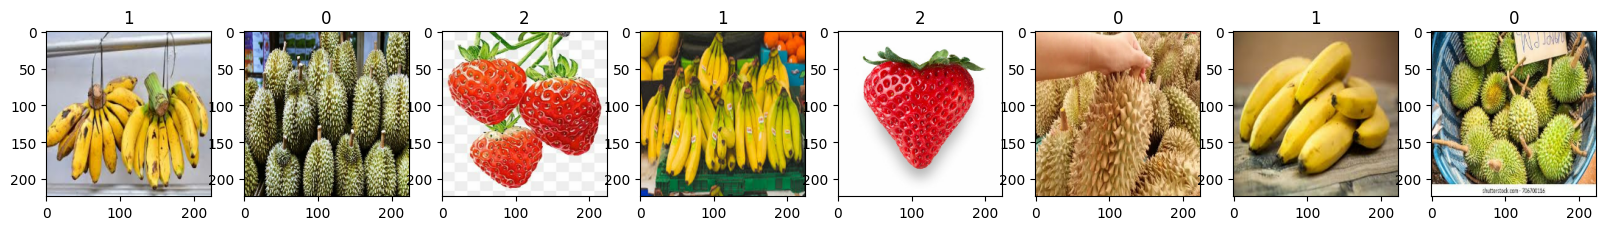

In [6]:
#tampilkan gambar yang akan digunakan untuk melatih model menggunakan library matplotlib
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [7]:
#normalisasi data
data = data.map(lambda x, y: (x/255.0, y))
print("Data type after normalization: {}".format(data.element_spec))
print("Data shape after normalization: {}".format(data.element_spec))
print("Jumlah data", len(data))

Data type after normalization: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Data shape after normalization: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Jumlah data 39


In [8]:
# bagi data menjadi train, validation, dan test set dengan rasio 80:10:10
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.1)
test_size = int(len(data)*0.1)

print(train_size)
print(val_size)
print(test_size)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

31
3
3


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def identity_block(X, f, filters):
    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s, s))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3)(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape = (224, 224, 3), classes = 3):
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), padding = 'same')(X_input)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL
    X = GlobalAveragePooling2D()(X)

    # Output layer
    X = Dense(classes, activation='softmax')(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

# Example usage:
model = ResNet50()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_53 (Conv2D)            │ (None, 112, 112, 64)      │           9,472 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_53        │ (None, 112, 112, 64)      │             256 │ conv2d_53[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_49 (Activation)    │ (None, 112, 112, 64)      │               0 │ batch_normalization_53[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 55, 55, 64)        │               0 │ activation_49[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_54 (Conv2D)            │ (None, 55, 55, 64)        │           4,160 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_54        │ (None, 55, 55, 64)        │             256 │ conv2d_54[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_50 (Activation)    │ (None, 55, 55, 64)        │               0 │ batch_normalization_54[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_55 (Conv2D)            │ (None, 55, 55, 64)        │          36,928 │ activation_50[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_55        │ (None, 55, 55, 64)        │             256 │ conv2d_55[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_51 (Activation)    │ (None, 55, 55, 64)        │               0 │ batch_normalization_55[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_56 (Conv2D)            │ (None, 55, 55, 256)       │          16,640 │ activation_51[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_57 (Conv2D)            │ (None, 55, 55, 256)       │          16,640 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_56        │ (None, 55, 55, 256)       │           1,024 │ conv2d_56[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_57        │ (None, 55, 55, 256)       │           1,02

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
history_resnet = model.fit(train, epochs=20, validation_data = val)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5626 - loss: 2.4748 - val_accuracy: 0.3750 - val_loss: 1.5235
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7675 - loss: 0.6376 - val_accuracy: 0.2500 - val_loss: 2.7923
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8074 - loss: 0.7545 - val_accuracy: 0.2917 - val_loss: 2.7153
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8448 - loss: 0.4906 - val_accuracy: 0.4583 - val_loss: 2.5180
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8145 - loss: 0.6288 - val_accuracy: 0.5833 - val_loss: 1.9498
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8777 - loss: 0.4119 - val_accuracy: 0.4583 - val_loss: 2.1773
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9050 - loss: 0.2989 - val_accuracy: 0.5417 - val_loss: 3.2027
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9100 - loss: 0.3419 - val_accuracy: 0.2500 - val_loss:

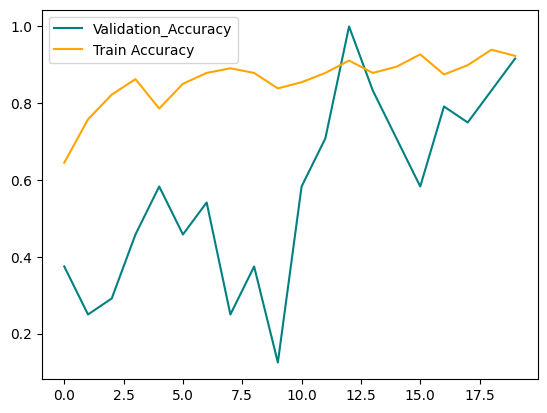

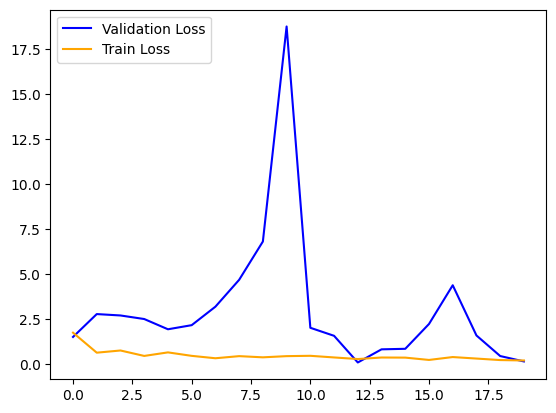

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step - accuracy: 0.9792 - loss: 0.0848


[0.13223445415496826, 0.9583333134651184]

In [15]:
fig = plt.figure()
plt.plot(history_resnet.history['val_accuracy'], color='teal', label='Validation_Accuracy')
plt.plot(history_resnet.history['accuracy'], color='orange', label='Train Accuracy')
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(history_resnet.history['val_loss'], color='blue', label='Validation Loss')
plt.plot(history_resnet.history['loss'], color='orange', label='Train Loss')
plt.legend(loc="upper left")
plt.show()

model.evaluate(test)

In [16]:
# Save the model
model.save('C:/Users/Asus/Downloads/PMDPM/TUBES ML2/resnet_buah_ver2.h5')

In [17]:
model = tf.keras.models.load_model('C:/Users/Asus/Downloads/PMDPM/TUBES ML2/resnet_buah_ver2.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


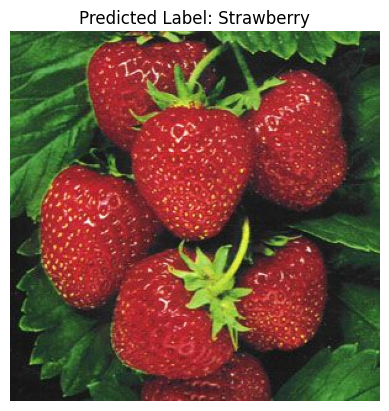

Predicted Label: Strawberry
Confidence: 100.00%
Pred : [[1.0583243e-06 1.1980452e-06 9.9999774e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


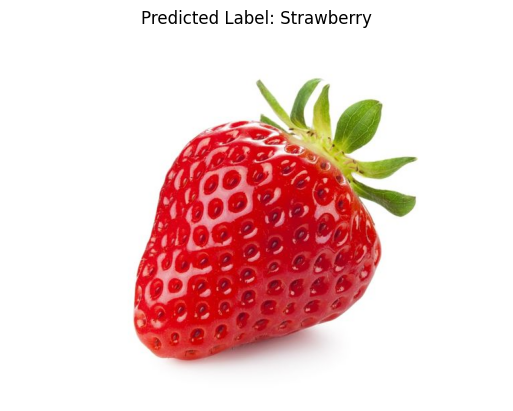

Predicted Label: Strawberry
Confidence: 100.00%
Pred : [[2.7840388e-08 2.0671470e-08 1.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


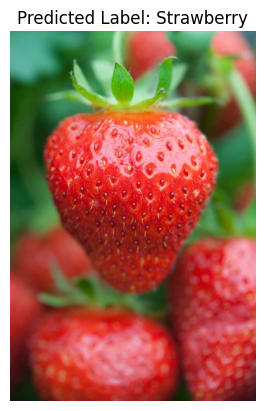

Predicted Label: Strawberry
Confidence: 100.00%
Pred : [[4.889262e-07 1.886545e-07 9.999993e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


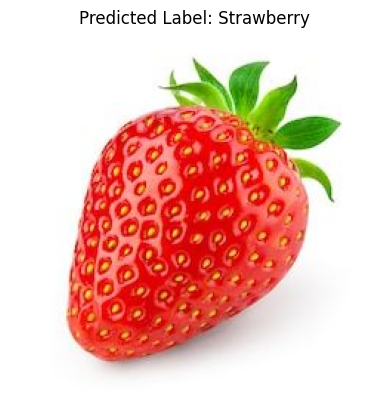

Predicted Label: Strawberry
Confidence: 100.00%
Pred : [[2.8084550e-08 2.8385701e-08 1.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


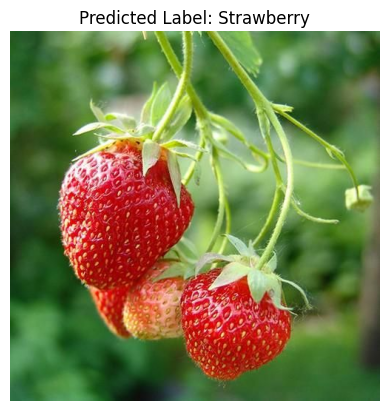

Predicted Label: Strawberry
Confidence: 100.00%
Pred : [[6.3549310e-06 1.7328522e-06 9.9999189e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


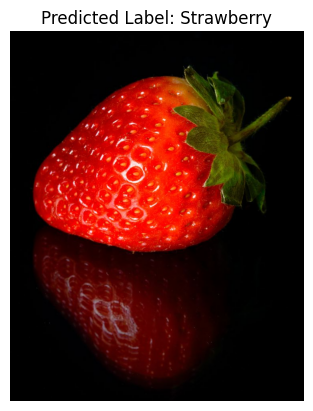

Predicted Label: Strawberry
Confidence: 100.00%
Pred : [[2.8503986e-11 1.8284733e-15 1.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


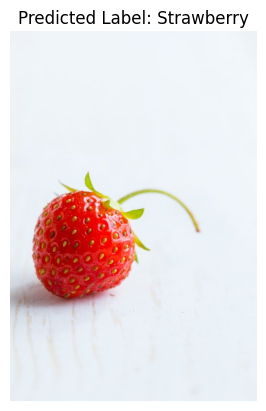

Predicted Label: Strawberry
Confidence: 99.93%
Pred : [[1.8451743e-05 6.3285948e-04 9.9934870e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


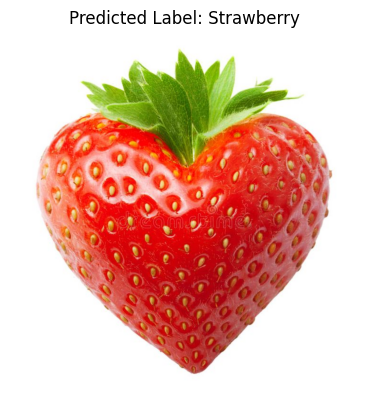

Predicted Label: Strawberry
Confidence: 100.00%
Pred : [[8.5844389e-09 1.9085766e-09 1.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


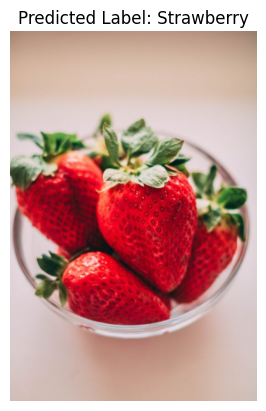

Predicted Label: Strawberry
Confidence: 100.00%
Pred : [[2.1978249e-11 2.8205789e-14 1.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


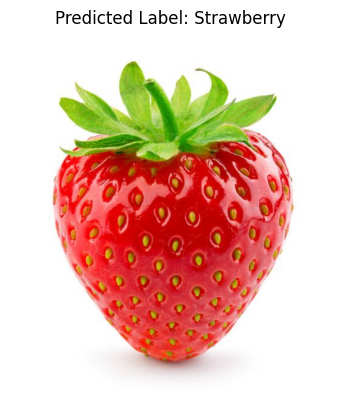

Predicted Label: Strawberry
Confidence: 100.00%
Pred : [[5.7382205e-10 2.4036081e-10 1.0000000e+00]]


In [18]:
# Folder containing the images
image_folder = 'C:/Users/Asus/Downloads/PMDPM/TUBES ML2/dataset/test/Strawberry'

# List of images in the folder
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]

# Class names
class_names = ['Durian', 'Pisang', 'Strawberry']

# Predict and annotate each image
for image_file in image_files:
    # Load image
    img = cv2.imread(image_file)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize and normalize image for the model
    input_image = cv2.resize(img_rgb, (224,224))
    input_image = input_image / 255.0
    input_image = np.expand_dims(input_image, axis=0)

    # Predict using the model
    pred = model.predict(input_image)
    label_index = np.argmax(pred)
    confidence = pred[0][label_index] * 100

    predicted_label = class_names[label_index]

    # Display the image with Matplotlib
    plt.figure()
    plt.title(f'Predicted Label: {predicted_label}')
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    
    print(f'Predicted Label: {predicted_label}')
    print(f'Confidence: {confidence:.2f}%')
    print(f'Pred : {pred}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


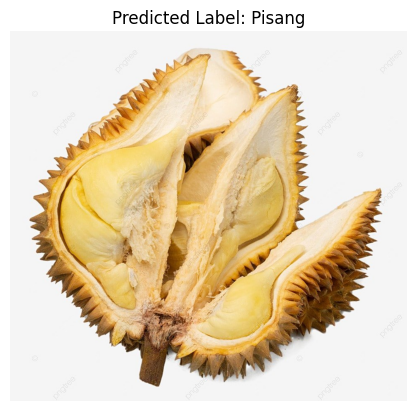

Predicted Label: Pisang
Confidence: 97.68%
Pred : [[0.0157039  0.97680944 0.00748667]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


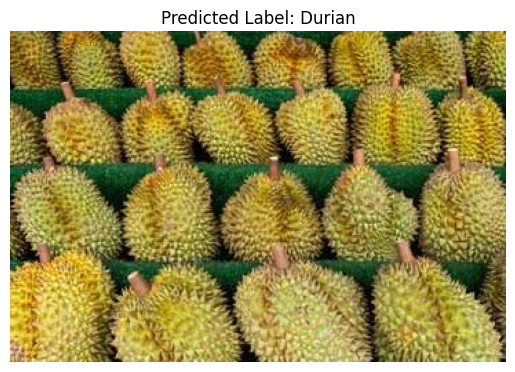

Predicted Label: Durian
Confidence: 98.87%
Pred : [[0.9887483  0.00602822 0.00522348]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


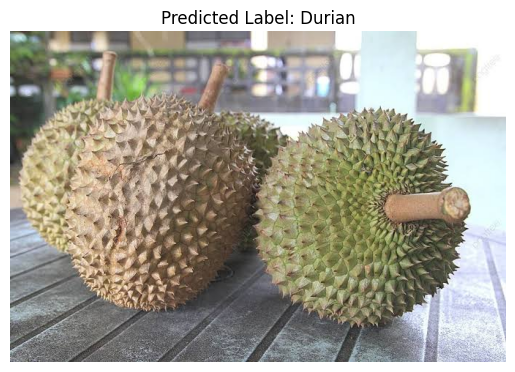

Predicted Label: Durian
Confidence: 95.96%
Pred : [[0.95961314 0.0231557  0.01723118]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


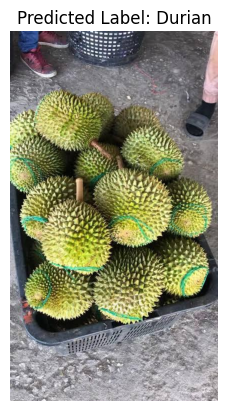

Predicted Label: Durian
Confidence: 94.62%
Pred : [[0.9461752  0.03693423 0.01689049]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


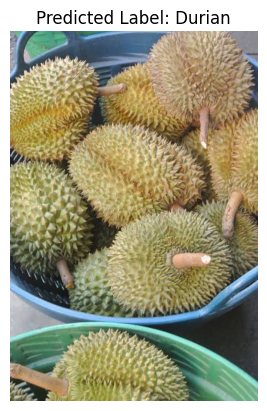

Predicted Label: Durian
Confidence: 95.64%
Pred : [[0.9563801  0.03088724 0.01273273]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


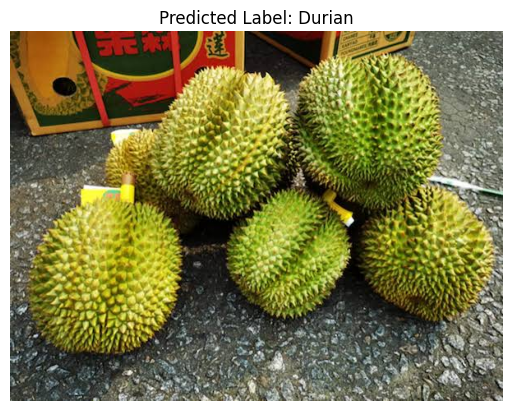

Predicted Label: Durian
Confidence: 98.61%
Pred : [[0.9861086  0.00104551 0.0128459 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


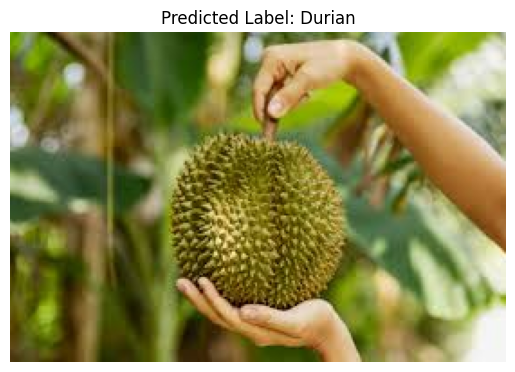

Predicted Label: Durian
Confidence: 98.90%
Pred : [[0.98896027 0.00473128 0.00630852]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


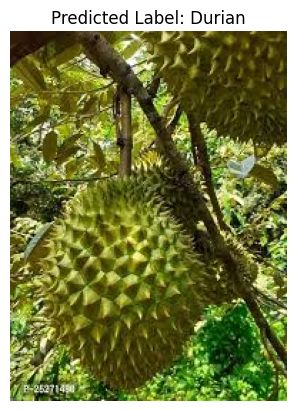

Predicted Label: Durian
Confidence: 99.82%
Pred : [[9.9823618e-01 2.1022553e-05 1.7427244e-03]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


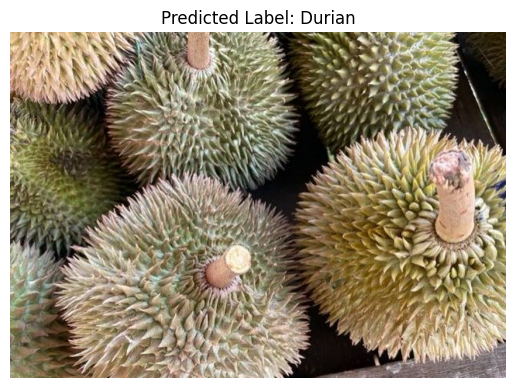

Predicted Label: Durian
Confidence: 99.32%
Pred : [[0.9931988  0.00139869 0.00540257]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


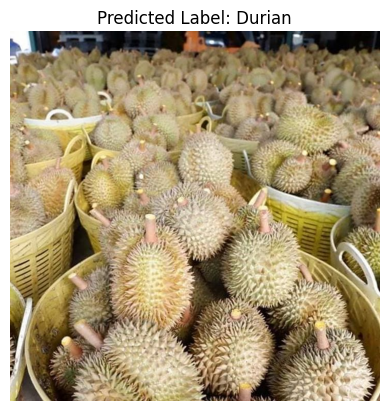

Predicted Label: Durian
Confidence: 77.49%
Pred : [[0.7748709  0.20630126 0.01882783]]


In [40]:
# Folder containing the images
image_folder = 'C:/Users/Asus/Downloads/PMDPM/TUBES ML2/dataset/test/Durian'

# List of images in the folder
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]

# Class names
class_names = ['Durian', 'Pisang', 'Strawberry']

# Predict and annotate each image
for image_file in image_files:
    # Load image
    img = cv2.imread(image_file)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize and normalize image for the model
    input_image = cv2.resize(img_rgb, (224,224))
    input_image = input_image / 255.0
    input_image = np.expand_dims(input_image, axis=0)

    # Predict using the model
    pred = model.predict(input_image)
    label_index = np.argmax(pred)
    confidence = pred[0][label_index] * 100

    predicted_label = class_names[label_index]

    # Display the image with Matplotlib
    plt.figure()
    plt.title(f'Predicted Label: {predicted_label}')
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    
    print(f'Predicted Label: {predicted_label}')
    print(f'Confidence: {confidence:.2f}%')
    print(f'Pred : {pred}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


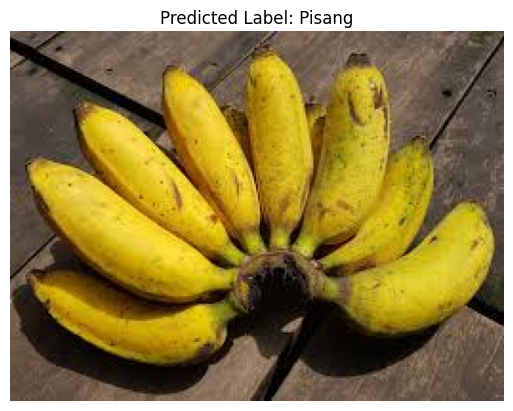

Predicted Label: Pisang
Confidence: 99.99%
Pred : [[6.2675157e-05 9.9993527e-01 2.0982047e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


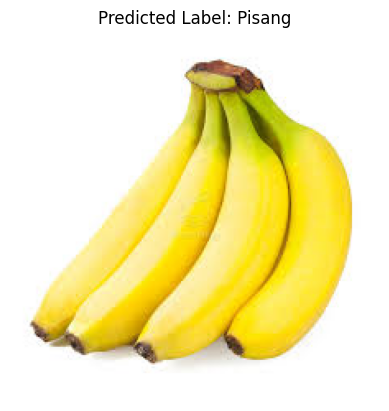

Predicted Label: Pisang
Confidence: 99.97%
Pred : [[2.0891712e-04 9.9973291e-01 5.8180023e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


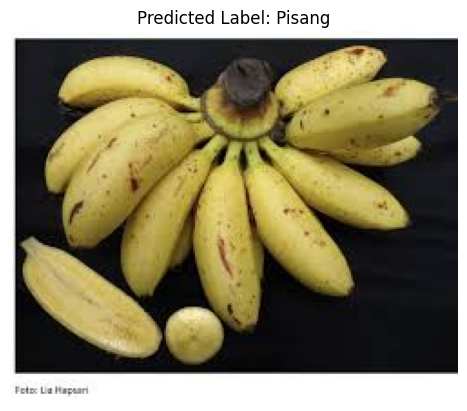

Predicted Label: Pisang
Confidence: 96.88%
Pred : [[0.02570043 0.9687507  0.00554881]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


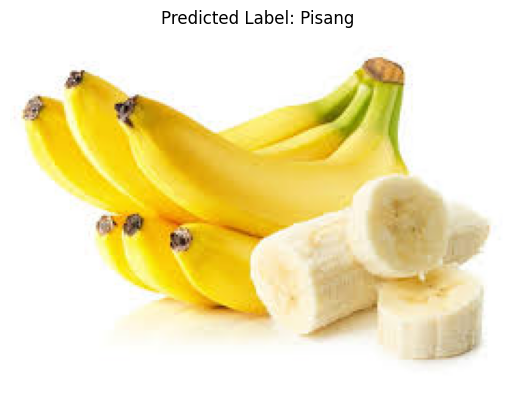

Predicted Label: Pisang
Confidence: 99.85%
Pred : [[1.1053954e-03 9.9850118e-01 3.9343897e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


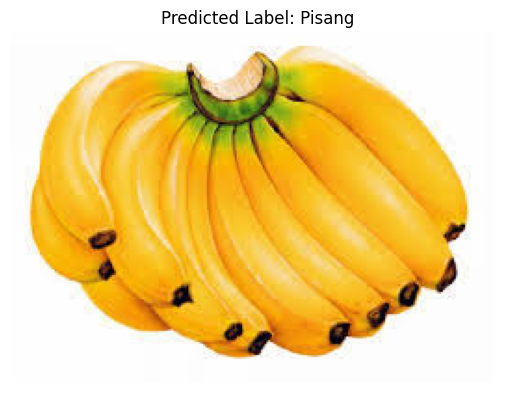

Predicted Label: Pisang
Confidence: 100.00%
Pred : [[1.0764668e-05 9.9998879e-01 4.1417374e-07]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


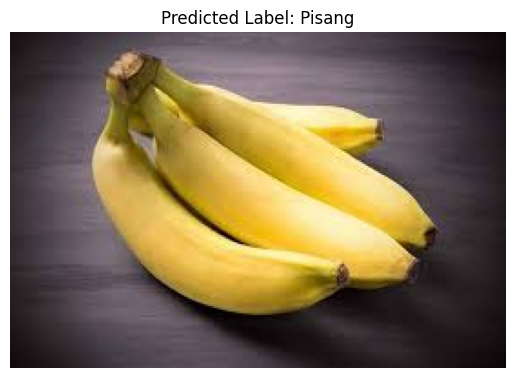

Predicted Label: Pisang
Confidence: 99.71%
Pred : [[0.00145801 0.99712247 0.00141951]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


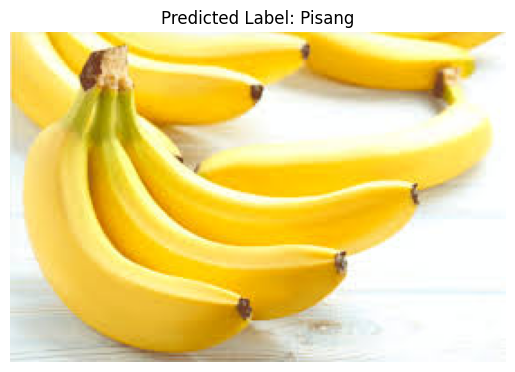

Predicted Label: Pisang
Confidence: 99.99%
Pred : [[5.0117156e-05 9.9994540e-01 4.4720550e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


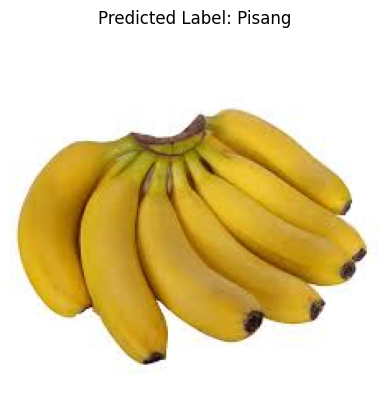

Predicted Label: Pisang
Confidence: 100.00%
Pred : [[4.0772895e-05 9.9995542e-01 3.7498307e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


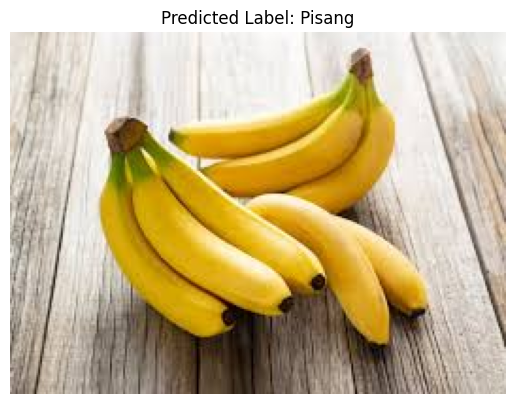

Predicted Label: Pisang
Confidence: 99.98%
Pred : [[1.5352153e-04 9.9982721e-01 1.9333887e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


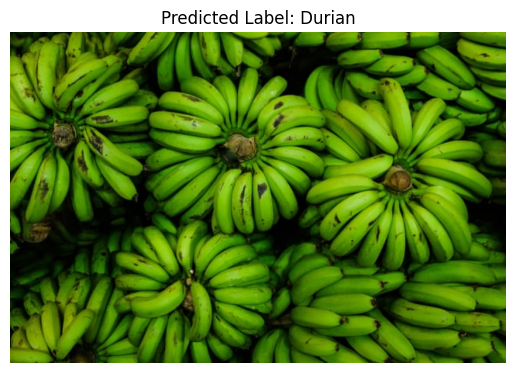

Predicted Label: Durian
Confidence: 99.78%
Pred : [[9.9784315e-01 2.2140683e-05 2.1346912e-03]]


In [39]:
# Folder containing the images
image_folder = 'C:/Users/Asus/Downloads/PMDPM/TUBES ML2/dataset/test/Pisang'

# List of images in the folder
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]

# Class names
class_names = ['Durian', 'Pisang', 'Strawberry']

# Predict and annotate each image
for image_file in image_files:
    # Load image
    img = cv2.imread(image_file)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize and normalize image for the model
    input_image = cv2.resize(img_rgb, (224,224))
    input_image = input_image / 255.0
    input_image = np.expand_dims(input_image, axis=0)

    # Predict using the model
    pred = model.predict(input_image)
    label_index = np.argmax(pred)
    confidence = pred[0][label_index] * 100

    predicted_label = class_names[label_index]

    # Display the image with Matplotlib
    plt.figure()
    plt.title(f'Predicted Label: {predicted_label}')
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    
    print(f'Predicted Label: {predicted_label}')
    print(f'Confidence: {confidence:.2f}%')
    print(f'Pred : {pred}')
